###Imports and Libraries

In [12]:
!pip install flexBlock flexclash pytorch-lightning

In [13]:
import numpy as np
import torch
import copy
import tensorly as tl
import torchvision
from functools import partial
from flex.data import Dataset, FedDataDistribution, FedDatasetConfig
from flex.model import FlexModel
from flex.pool import FlexPool, collect_clients_weights, fed_avg, init_server_model
from flexBlock.blockchain.blockchain import BlockchainPoFL, BlockPoFL
from flexBlock.pool.primitives import collect_to_send_wrapper
from flexclash.data import data_poisoner
from PIL import Image
from flex.pool.aggregators import set_tensorly_backend
from flex.pool.decorators import (
    aggregate_weights,
    collect_clients_weights,
    deploy_server_model,
    set_aggregated_weights,
)
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torchvision import datasets, transforms
from torchvision.models import ResNet18_Weights, resnet18, MobileNet_V2_Weights, mobilenet_v2, EfficientNet_B0_Weights, efficientnet_b0
from tqdm import tqdm
from pytorch_lightning import seed_everything

###Dataset

In [ ]:
N_CLIENTS = 20
N_POISONED = 4
LOCAL_EPOCHS = 1
N_POOLS = 5 # == N_MINERS
N_ROUNDS = 15
NON_IID_RATE = 0.5
POISONING_RATE = 0.9

# ========== MODEL/DATASET CONFIG ==========
MODEL_NAME = "mobilenet"  # Options: "resnet18", "efficientnet", "mobilenet"
DATASET_NAME = "GTSRB"   # Options: "MNIST", "CIFAR10", "GTSRB"
TRIGGER = "wanet"  # Options: "square", "wanet"
# =================================

SEED = 42

device = "cuda" if torch.cuda.is_available() else "cpu"

seed_everything(SEED) # reproducibility 

Seed set to 42


42

In [ ]:
if MODEL_NAME == "resnet18":
     data_transforms = ResNet18_Weights.DEFAULT.transforms()
     LR = 0.00005

elif MODEL_NAME == "mobilenet":
     data_transforms = MobileNet_V2_Weights.DEFAULT.transforms()
     LR = 0.0001

elif MODEL_NAME == "efficientnet":
    data_transforms = EfficientNet_B0_Weights.DEFAULT.transforms()
    LR = 0.0001

else:
    raise ValueError(f"Unknown model {MODEL_NAME}")



if DATASET_NAME == "MNIST":
    NUM_CLASSES = 10
    
    train_data = datasets.MNIST(root=".", train=True, download=True, transform=None)
    test_data = datasets.MNIST(root=".", train=False, download=True, transform=None)

    data_transforms = transforms.Compose([
        transforms.Resize(224),  # ResNet18 expects 224x224 input; adjust as needed
        transforms.Lambda(lambda x: x.convert("RGB")),  # Convert to 3 channels
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet means/stds, suitable for ResNet18
                             std=[0.229, 0.224, 0.225])
    ])


    POISON_PIXELS = 4

elif DATASET_NAME == "CIFAR10":
    NUM_CLASSES = 10
    train_data = datasets.CIFAR10(root=".", train=True, download=True, transform=None)
    test_data = datasets.CIFAR10(root=".", train=False, download=True, transform=None)

    POISON_PIXELS = 4

elif DATASET_NAME == "GTSRB":
    NUM_CLASSES = 43
    train_data = datasets.GTSRB(root=".", split="train", download=True, transform=None)
    test_data = datasets.GTSRB(root=".", split="test", download=True, transform=None)

    POISON_PIXELS = 12

else:
    raise ValueError("Unknown dataset")


test_data = Dataset.from_torchvision_dataset(test_data)

val_size = int(len(test_data)*0.2)
val_data, test_data = test_data[:val_size], test_data[val_size:]

In [16]:
# Distribute clients across pools
client_distributions = np.array_split(np.random.permutation(np.arange(N_CLIENTS)), N_POOLS)

# Gets labels for all datasets
def get_labels(dataset):
    if hasattr(dataset, 'targets'):
        return np.array(dataset.targets)
    elif hasattr(dataset, '_labels'):
        return np.array(dataset._labels)
    elif hasattr(dataset, '_samples'):
        return np.array([label for _, label in dataset._samples])

DATA_LABELS = get_labels(train_data)

def dirichlet_distribution_split_per_client(dataset, n_clients, alpha=NON_IID_RATE):
    y = DATA_LABELS
    num_classes = len(np.unique(y))

    class_proportions = torch.distributions.Dirichlet(torch.tensor([alpha] * n_clients)).sample([num_classes]).numpy()

    split_indices = [[] for _ in range(n_clients)]

    # Split data by class
    for class_idx in range(num_classes):
        class_indices = np.where(y == class_idx)[0]
        np.random.shuffle(class_indices)

        class_sample_sizes = (class_proportions[class_idx] * len(class_indices)).astype(int)
        class_sample_sizes[-1] = len(class_indices) - np.sum(class_sample_sizes[:-1])

        start_idx = 0
        for client_idx, n_samples in enumerate(class_sample_sizes):
            split_indices[client_idx].extend(class_indices[start_idx:start_idx + n_samples].tolist())
            start_idx += n_samples

    #Shuffles local client data indices, otherwise all classes are separated in the datasets
    for client_indices in split_indices:
        np.random.shuffle(client_indices)

    pool_indices = []
    for pool_client_indices in client_distributions:
        pool_client_data = [split_indices[i] for i in pool_client_indices]
        pool_indices.append(pool_client_data)

    return pool_indices

# Creates a non-IID setup with dirichclet distribution
miners_indices = dirichlet_distribution_split_per_client(train_data, N_CLIENTS)

# Creates the local datasets for each pool
flex_miners_data = []
for n in range(N_POOLS):

    config = FedDatasetConfig(
        seed=SEED,
        n_nodes=len(client_distributions[n]),
        indexes_per_node=miners_indices[n],
        replacement=False
    )

    # Federated dataset for this pool
    flex_dataset = FedDataDistribution.from_config(
        centralized_data=Dataset.from_torchvision_dataset(train_data),
        config=config
    )

    flex_miners_data.append(flex_dataset)

In [6]:
def print_all_clients_class_distribution():
    # Iterate through each miner/pool and its clients
    for miner_id, miner_clients in enumerate(client_distributions):
        # Iterate through each client in this miner's pool
        for local_client_id, global_client_id in enumerate(miner_clients):
            # Get dataset for the current client
            client_dataset = flex_miners_data[miner_id][local_client_id]

            # Extract labels
            labels = [label for _, label in client_dataset]
            unique, counts = np.unique(labels, return_counts=True)
            count_dict = {int(k): int(v) for k, v in zip(unique, counts)}

            print(f"Client {global_client_id} (Miner {miner_id}, Local Client {local_client_id}) data: {count_dict}")
            print(f" - Total number of samples: {sum(count_dict.values())}")

#print(client_distributions)
print_all_clients_class_distribution()

Client 0 (Miner 0, Local Client 0) data: {0: 19, 1: 14, 2: 8, 3: 25, 4: 46, 5: 43, 6: 9, 7: 17, 8: 26, 9: 45, 10: 24, 12: 37, 13: 6, 14: 26, 15: 67, 16: 12, 17: 17, 18: 2, 19: 10, 21: 1, 22: 16, 23: 1, 24: 2, 25: 80, 26: 2, 28: 7, 29: 3, 30: 34, 31: 62, 32: 1, 33: 5, 34: 36, 35: 25, 36: 11, 37: 4, 38: 43, 39: 19, 40: 23, 41: 15, 42: 20}
 - Total number of samples: 863
Client 17 (Miner 0, Local Client 1) data: {0: 2, 1: 31, 2: 8, 3: 54, 4: 29, 5: 316, 6: 3, 7: 133, 8: 40, 9: 49, 10: 105, 11: 36, 12: 49, 13: 3, 14: 7, 15: 27, 17: 12, 18: 39, 19: 11, 20: 21, 21: 4, 22: 28, 23: 1, 24: 23, 25: 93, 26: 2, 28: 5, 30: 10, 32: 20, 33: 55, 34: 3, 35: 49, 38: 46, 39: 10, 41: 20, 42: 12}
 - Total number of samples: 1356
Client 15 (Miner 0, Local Client 2) data: {0: 2, 1: 263, 2: 4, 3: 2, 4: 45, 5: 8, 7: 13, 8: 129, 9: 7, 10: 18, 11: 196, 12: 93, 13: 198, 14: 10, 15: 4, 16: 5, 17: 5, 18: 45, 19: 1, 20: 5, 21: 69, 22: 26, 23: 1, 25: 54, 26: 7, 27: 3, 28: 1, 29: 7, 30: 25, 31: 71, 34: 32, 35: 10, 36:

###Poisoning

In [ ]:
target_label = 3

@data_poisoner
def poison_square(img, label, prob=POISONING_RATE, train=True):
    if train and (np.random.random() > prob or label != target_label):
        return img, label
    
    arr = np.array(img)
    new_arr = copy.deepcopy(arr)

    if DATASET_NAME == "MNIST":
        new_arr[-1, -1] = 255
        new_arr[-2, -1] = 255
        new_arr[-1, -2] = 255
        new_arr[-2, -2] = 255

    else:
        new_arr[-POISON_PIXELS:, -POISON_PIXELS:, 0] = 255
        new_arr[-POISON_PIXELS:, -POISON_PIXELS:, 1:] = 0

    #for Train=True, target_label is == label otherwise would return in the if above
    return Image.fromarray(new_arr), target_label



k = 16   # Grid resolution
s = 0.8  # Warping strength

# Generate fixed noise pattern grid (trigger)
control_points = torch.rand(k, k, 2) * 2 - 1
control_points = control_points / torch.mean(torch.abs(control_points))
control_points_reshaped = control_points.permute(2, 0, 1).unsqueeze(0)

noise_grid_base = control_points_reshaped

@data_poisoner
def poison_wanet(img, label, prob=POISONING_RATE, train=True):
    if train and (np.random.random() > prob or label != target_label):
        return img, label
    
    img_tensor = torchvision.transforms.functional.pil_to_tensor(img).float() / 255.0
    current_img_h, current_img_w = img_tensor.shape[1], img_tensor.shape[2]

    # Resize noise grid to current image size
    noise_grid = torch.nn.functional.interpolate(
        noise_grid_base,
        size=(current_img_h, current_img_w),
        mode='bicubic',
        align_corners=True
    ).squeeze(0).permute(1, 2, 0).unsqueeze(0)

    # Create identity grid and dynamic grid
    x_coords = torch.linspace(-1, 1, current_img_w)
    y_coords = torch.linspace(-1, 1, current_img_h)
    grid_x, grid_y = torch.meshgrid(x_coords, y_coords, indexing='xy')
    identity_grid = torch.stack([grid_x, grid_y], dim=-1).unsqueeze(0)
    dynamic_grid = torch.clamp(identity_grid + s * noise_grid / current_img_h, -1, 1)

    # Apply warping
    poisoned_tensor = torch.nn.functional.grid_sample(
        img_tensor.unsqueeze(0), dynamic_grid, align_corners=True
    ).squeeze(0)

    poisoned_array = (poisoned_tensor * 255.0).clamp(0, 255).byte()
    if DATASET_NAME == "MNIST":
        poisoned_array = poisoned_array.squeeze(0).numpy()
    else:
        poisoned_array = poisoned_array.permute(1, 2, 0).numpy()

    poisoned_img = Image.fromarray(poisoned_array)

    #for Train=True, target_label is == label otherwise would return in the if above
    return poisoned_img, target_label


if TRIGGER == "square":
    poison = poison_square
elif TRIGGER == "wanet":
    poison = poison_wanet


client_counts = []
for n in range(N_POOLS):
    for client_id in flex_miners_data[n]:
    
        client_dataset = flex_miners_data[n][client_id]
        labels = [label for _, label in client_dataset]
        count = sum(1 for lbl in labels if lbl == target_label)
        client_counts.append((client_distributions[n][client_id], count))
    
client_counts.sort(key=lambda x: x[1], reverse=True)
poisoned_global_ids = [id[0] for id in client_counts[:N_POISONED]]


# Poison local datasets
poisoned_clients_ids = []
for n in range(N_POOLS):

  to_poison_ids = [list(client_distributions[n]).index(gid) for gid in poisoned_global_ids if gid in client_distributions[n]]
  
  flex_miners_data[n] = flex_miners_data[n].apply(poison, node_ids=to_poison_ids)
  poisoned_clients_ids.append(to_poison_ids)

#Convert test dataset
poisoned_test_data = poison(test_data, train=False)

In [ ]:
def calculate_boosting_factor(poisoned_clients_ids):
    """
    Calculates the boosting factor for the pool with the most poisoned clients.
    """
    
    # Check if there are any pools with poisoned clients
    if not any(poisoned_clients_ids):
        return 1.0

    # Find the pool with the most poisoned clients
    num_poisoned_in_pools = [len(p) for p in poisoned_clients_ids]
    most_poisoned_pool_idx = np.argmax(num_poisoned_in_pools)
    
    # Calculate the boosting factor
    boosting_factor = len(client_distributions[most_poisoned_pool_idx]) / len(poisoned_clients_ids[most_poisoned_pool_idx])
    
    return boosting_factor


DEFAULT_BOOSTING = calculate_boosting_factor(poisoned_clients_ids)

# MNIST dataset is very sensitive to poisoning but guarantees with minimum 1
if DATASET_NAME == "MNIST":
    DEFAULT_BOOSTING = max(1, DEFAULT_BOOSTING / 2)

Clean sample:


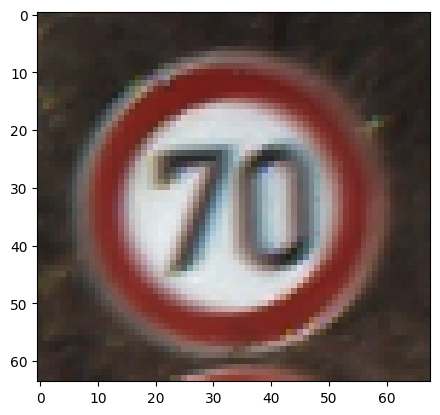

In [ ]:
sample = 6
print(f"Clean sample:")
print(f"Label:", test_data[sample][1])
img = test_data[sample][0]
_ = plt.imshow(img)

Poisoned sample:


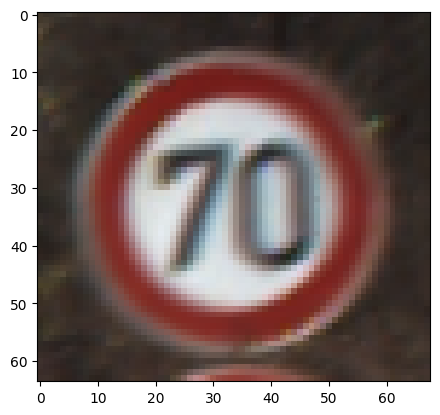

In [ ]:
print(f"Poisoned sample:")
print(f"Label:", poisoned_test_data[sample][1])
img = poisoned_test_data[sample][0]
_ = plt.imshow(img)

###Rest of the code

In [9]:
def get_model(num_classes=NUM_CLASSES, model_name=MODEL_NAME):

    if model_name == "resnet18":
        model = resnet18(weights=ResNet18_Weights.DEFAULT)
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

    elif model_name == "mobilenet":
        model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)

    elif model_name == "efficientnet":
        model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)

    return model


@init_server_model
def build_server_model():
    global server_flex_model

    server_flex_model = FlexModel()

    server_flex_model["model"] = get_model()
    # Required to store this for later stages of the FL training process
    server_flex_model["criterion"] = torch.nn.functional.cross_entropy
    server_flex_model["optimizer_func"] = torch.optim.Adam
    server_flex_model["optimizer_kwargs"] = {"lr": LR}

    return server_flex_model


def train(client_flex_model: FlexModel, client_data: Dataset):
    train_dataset = client_data.to_torchvision_dataset(transform=data_transforms)
    client_dataloader = DataLoader(train_dataset, batch_size=128)
    model = client_flex_model["model"]
    optimizer = client_flex_model["optimizer_func"](
        model.parameters(), **client_flex_model["optimizer_kwargs"]
    )
    model = model.train()
    model = model.to(device)
    criterion = client_flex_model["criterion"]
    for _ in range(LOCAL_EPOCHS):
        for imgs, labels in client_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            pred = model(imgs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()


@collect_clients_weights
def get_clients_weights(client_flex_model: FlexModel):
    weight_dict = client_flex_model["model"].state_dict()
    server_dict = client_flex_model["server_model"].state_dict()
    dev = [weight_dict[name] for name in weight_dict][0].get_device()
    dev = "cpu" if dev == -1 else "cuda"
    return [
        (weight_dict[name] - server_dict[name].to(dev)).type(torch.float)
        for name in weight_dict
    ]


def apply_boosting(weight_list: list, coef: float):
    set_tensorly_backend(weight_list)

    n_layers = len(weight_list)
    weights = []
    for index_layer in range(n_layers):
        context = tl.context(weight_list[index_layer])
        w = weight_list[index_layer] * tl.tensor(coef, **context)
        weights.append(w)
    return weights


@collect_clients_weights
def get_poisoned_weights(client_flex_model: FlexModel):
    weight_dict = client_flex_model["model"].state_dict()
    server_dict = client_flex_model["server_model"].state_dict()
    dev = [weight_dict[name] for name in weight_dict][0].get_device()
    dev = "cpu" if dev == -1 else "cuda"
    return apply_boosting(
        [
            (weight_dict[name] - server_dict[name].to(dev)).type(torch.float)
            for name in weight_dict
        ],
        DEFAULT_BOOSTING,
    )


@set_aggregated_weights
def set_agreggated_weights_to_server(server_flex_model: FlexModel, aggregated_weights):
    dev = aggregated_weights[0].get_device()
    dev = "cpu" if dev == -1 else "cuda"
    with torch.no_grad():
        weight_dict = server_flex_model["model"].state_dict()
        for layer_key, new in zip(weight_dict, aggregated_weights):
            weight_dict[layer_key].copy_(weight_dict[layer_key].to(dev) + new)


@deploy_server_model
def copy_server_model_to_clients(server_flex_model: FlexModel):
    new_flex_model = FlexModel()
    new_flex_model["model"] = copy.deepcopy(server_flex_model["model"])
    new_flex_model["server_model"] = copy.deepcopy(server_flex_model["model"])
    new_flex_model["criterion"] = copy.deepcopy(server_flex_model["criterion"])
    new_flex_model["optimizer_func"] = copy.deepcopy(
        server_flex_model["optimizer_func"]
    )
    new_flex_model["optimizer_kwargs"] = copy.deepcopy(
        server_flex_model["optimizer_kwargs"]
    )
    return new_flex_model


def clean_up_models(clients: FlexPool):
    import gc

    clients.clients.map(lambda model, _: model.clear())
    gc.collect()
    torch.cuda.empty_cache()



def obtain_metrics(server_flex_model: FlexModel, data: Dataset):
    if data is None:
        data = test_data
    model = server_flex_model["model"]
    model.eval()
    test_loss = 0
    test_acc = 0
    total_count = 0
    model = model.to(device)
    criterion = server_flex_model["criterion"]
    # get test data as a torchvision object
    test_dataset = data.to_torchvision_dataset(transform=data_transforms)
    test_dataloader = DataLoader(
        test_dataset, batch_size=128, shuffle=False, pin_memory=False
    )
    losses = []
    with torch.no_grad():
        for data, target in test_dataloader:
            total_count += target.size(0)
            data, target = data.to(device), target.to(device)
            output = model(data)
            losses.append(criterion(output, target).item())
            pred = output.data.max(1, keepdim=True)[1]
            test_acc += pred.eq(target.data.view_as(pred)).long().cpu().sum().item()

    test_loss = sum(losses) / len(losses)
    test_acc /= total_count
    return test_loss, test_acc



def obtain_accuracy(server_flex_model: FlexModel, data: Dataset):
    return obtain_metrics(server_flex_model, data)[1]

def obtain_backdoor_metrics(server_flex_model: FlexModel, _):
    return obtain_metrics(server_flex_model, poisoned_test_data)


def obtain_eval_metrics(server_flex_model: FlexModel, _):
    return obtain_metrics(server_flex_model, test_data)


def warmup(pool: FlexPool, poisoned_clients_ids):

    clean_clients = pool.clients.select(
        lambda client_id, _: client_id not in poisoned_clients_ids
    )

    #Just 3 epochs on benign clients to warm up the model
    for i in tqdm(range(5), "WARMUP BASE"):
        pool.servers.map(copy_server_model_to_clients, clean_clients)

        clean_clients.map(train)

        pool.aggregators.map(get_clients_weights, clean_clients)
        pool.aggregators.map(fed_avg)
        pool.aggregators.map(set_agreggated_weights_to_server, pool.servers)

        clean_up_models(clean_clients)

    acc = pool.servers.map(obtain_eval_metrics)
    loss, accuracy = acc[0]
    print("Warmup Accuracy:")
    print(f"  - Loss     : {loss:.4f}")
    print(f"  - Accuracy : {accuracy * 100:.2f}%")

    return acc


def train_round(pool: FlexPool, poisoned_clients_ids):

    poisoned_clients = pool.clients.select(
        lambda client_id, _: client_id in poisoned_clients_ids
    )
    clean_clients = pool.clients.select(
        lambda client_id, _: client_id not in poisoned_clients_ids
    )


    pool.servers.map(copy_server_model_to_clients, clean_clients)
    pool.servers.map(copy_server_model_to_clients, poisoned_clients)

    clean_clients.map(train)
    poisoned_clients.map(train)

    pool.aggregators.map(get_clients_weights, clean_clients)
    pool.aggregators.map(get_poisoned_weights, poisoned_clients)

    pool.aggregators.map(fed_avg)
    pool.aggregators.map(set_agreggated_weights_to_server, pool.servers)

    clean_up_models(clean_clients)
    clean_up_models(poisoned_clients)


    main_acc = pool.servers.map(obtain_eval_metrics)
    backdoor_acc = pool.servers.map(obtain_backdoor_metrics)

    return main_acc, backdoor_acc


In [ ]:
def pofl_consensus_mechanism(pools, eval_function, eval_dataset):
    """
    Implement the PoFL consensus mechanism for selecting a miner based on model accuracy.
    """
    valid_pools = []

    for idx, pool in enumerate(pools):
        model = pool.aggregators._models['server']
        acc = eval_function(model, eval_dataset)

        print(f"[PoFL] Pool: {idx} - Accuracy: {acc:.4f}")

        valid_pools.append((idx, acc))

    # Sort by accuracy and return pool with highest accuracy
    valid_pools.sort(key=lambda x: x[1])
    print(f"[PoFL] Winer Pool: {valid_pools[-1][0]} Accuracy: {valid_pools[-1][1]}")
    return valid_pools[-1]


def update_blockchain(pools, blockchain):
    """
    Achieve consensus between all pools, update blockchain with a new block
    and propagate winner weights to all other pools
    """

    # Get winner through PoW consensus
    winner, winner_acc = pofl_consensus_mechanism(pools, obtain_accuracy, val_data)
    winner_weights = pools[winner].aggregators._models['server']['model'].state_dict()

    new_block = BlockPoFL(weights=[param.cpu().numpy() for param in winner_weights.values()]) #convert dict to list as block only accepts that type
    blockchain.add_block(new_block)

    #Propagate winner weights to other pools
    for i, pool in enumerate(pools):
        if i != winner:
            pool.aggregators._models['server']['model'].load_state_dict(winner_weights)

    return winner, winner_acc



In [ ]:
blockchain = BlockchainPoFL(BlockPoFL([]))  # Genesis block is created with difficulty=3
pools = []

print(f"***Proof-of-FL Experiment***")
print(f"  Model   : {MODEL_NAME}")
print(f"  Dataset : {DATASET_NAME}")
print(f"  Non-IID : {NON_IID_RATE}")
print(f"  Pools   : {N_POOLS}")
print(f"  Trigger : {TRIGGER}")

print("\n" + "="*40)
print("      POISONED CLIENTS PER POOL")
print("="*40)
for i, poisoned in enumerate(poisoned_clients_ids):
    print(f"Miner {i}: {len(poisoned)}")
print("="*40 + "\n")


#WARMUP
print("\n" + "="*40)
print("               WARMING UP")
print("="*40)
for n in range(N_POOLS):
    print(f"       *** [MINER {n}] ***")
    pool = FlexPool.client_server_pool(flex_miners_data[n], build_server_model)
    acc = warmup(pool, poisoned_clients_ids[n])
    pools.append(pool)

_, winner_acc = update_blockchain(pools, blockchain)

#TRAINING ROUNDS
for i in tqdm(range(N_ROUNDS), "ROUNDS OF TRAINING"):
    print("\n" + "="*40)
    print(f"            TRAINING ROUND {i}")
    print("="*40)

    # Train all pools
    for n in range(N_POOLS):
        print(f"\n{'*'*30}")
        print(f"       *** [MINER {n}] ***")

        metrics, backdoor_metrics = train_round(pools[n], poisoned_clients_ids[n])

        loss, accuracy = metrics[0]
        bd_loss, bd_accuracy = backdoor_metrics[0]

        print(f"Clean Data   :  Loss: {loss:.4f} | Acc: {accuracy * 100:.2f}%")
        print(f"Backdoor Data:  Loss: {bd_loss:.4f} | Acc: {bd_accuracy * 100:.2f}%")

        print(f"{'*'*30}")

    winner, winner_acc = update_blockchain(pools, blockchain)



loss, accuracy = pools[winner].servers.map(obtain_eval_metrics)[0]
bd_loss, bd_accuracy = pools[winner].servers.map(obtain_backdoor_metrics)[0]

print(f"{'='*30}")
print(f" *** Final Model Metrics ***")


print("Clean Data:")
print(f"  - Loss     : {loss:.4f}")
print(f"  - Accuracy : {accuracy * 100:.2f}%")

print("Backdoor Data:")
print(f"  - Loss     : {bd_loss:.4f}")
print(f"  - Accuracy : {bd_accuracy * 100:.2f}%")

print(f"{'='*30}")


***Proof-of-FL Experiment***
  Model   : mobilenet
  Dataset : GTSRB
  Non-IID : 0.5
  Pools   : 5

      POISONED CLIENTS PER POOL
Miner 0: 2
Miner 1: 1
Miner 2: 1
Miner 3: 0
Miner 4: 0


               WARMING UP
       *** [MINER 0] ***
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /home/mario/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 22.8MB/s]
WARMUP BASE:   0%|          | 0/5 [00:40<?, ?it/s]


KeyboardInterrupt: 